In [24]:
import matplotlib.pyplot as plt
import numpy as np
import os
# import PIL
import tensorflow as tf
import pickle as pickle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob
from random import shuffle

In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [3]:
# import pathlib
# data_dir = pathlib.Path('E:/Users/sentinel_industry/downloaded_aois/')


In [78]:
x_size = 230
y_size = 230
def load_features(name):
    decoded = name.decode("UTF-8")
    if os.path.exists(decoded):
        with open(decoded, 'rb') as f:
            file = pickle.load(f)
            label = tf.strings.split(tf.strings.split(name, '/')[-1], '\\')[-2]
            if label == 'coal':
                label = [1,0,0]
            elif label == 'steel':
                label = [0,1,0]
            else: label = [0,0,1]
            features = np.array([file['B02'][0][0:x_size,0:y_size], file['B03'][0][0:x_size,0:y_size], file['B04'][0][0:x_size,0:y_size],file['B08'][0][0:x_size,0:y_size]]).transpose(1,2,0)
            # features = np.expand_dims(features, axis=0)
            return features, label
            # I have commented the line below but this should return
            # the features and the label in a one hot vector
            # return file['features'], file['targets']
    else:
        print("Something went wrong!")
        exit(-1)

In [79]:
path = 'E:/Users/sentinel_industry/downloaded_aois/coal/'

pkl_files = glob.glob((path+"*.pickle"))


In [80]:
print(len(pkl_files))

2241


In [81]:
path_steel = 'E:/Users/sentinel_industry/downloaded_aois/steel/'
pkl_files_steel = glob.glob((path_steel+"*.pickle"))

In [82]:
path_steel_no_ind = 'E:/Users/sentinel_industry/downloaded_aois/steel/no_ind/'
pkl_files_steel_no_ind = glob.glob((path_steel_no_ind+"*.pickle"))

In [83]:
path_coal_no_ind = 'E:/Users/sentinel_industry/downloaded_aois/coal/no_ind/'
pkl_files_coal_no_ind = glob.glob((path_coal_no_ind+"*.pickle"))

In [84]:
print(len(pkl_files_steel))

1021


In [85]:
pkl_files = pkl_files + pkl_files_steel + pkl_files_steel_no_ind + pkl_files_coal_no_ind
shuffle(pkl_files)

In [86]:
# from itertools import chain

# pkl_files = list(chain.from_iterable(zip(pkl_files, pkl_files_steel)))


In [87]:
print(len(pkl_files))

7345


In [88]:
dataset_len=len(pkl_files)

In [89]:
dataset = tf.data.Dataset.from_tensor_slices((pkl_files))

def data_loader(filename):
    features, labels = tf.numpy_function(load_features, [filename], [tf.uint16, tf.int32])
    # features.set_shape((None, 242,242,4))
    # labels.set_shape(( 1))
    return features, labels

dataset = dataset.map(data_loader)
               # load_features, [filename], [tf.uint16, tf.string])))

In [90]:
dataset.shuffle(100)


train_size = np.floor(0.8 * dataset_len)
valid_size = np.floor(0.1 * dataset_len)
test_size = np.floor(0.1 * dataset_len)

train = dataset.take(train_size)
remaining = dataset.skip(train_size)
valid = remaining.take(valid_size)
test = remaining.skip(valid_size)

In [91]:
train = train.shuffle(100,  reshuffle_each_iteration=True)

In [92]:
in_seed = 42
resize_rescale_augment = tf.keras.Sequential([
    layers.RandomRotation(0.2, seed=in_seed, input_shape=(x_size,y_size,4)),
    # layers.RandomCrop(120,120, seed=in_seed, input_shape=(x_size,y_size,4)),
    layers.CenterCrop(120,120, ),
    layers.Rescaling(1./10000),#,input_shape=(240,240,4)),
    layers.RandomFlip("horizontal_and_vertical", seed=in_seed),
])

In [93]:
# dataset = dataset.map((
#   lambda x, y: (resize_and_rescale(x), y)))

In [94]:
for image_batch, labels_batch in dataset:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(230, 230, 4)
(3,)


In [95]:
train

<ShuffleDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.uint16, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>

In [137]:
# model = tf.keras.Sequential([
#     resize_rescale_augment,
#     layers.Conv2D(16, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(32, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(3)
# ])
model = tf.keras.Sequential([
    resize_rescale_augment,
    layers.Conv2D(3, 5, padding='same', activation='relu'),
    tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights=None,
    input_shape=(120, 120, 3),
    pooling=max ,
    classes=3,),
    layers.Flatten(),
    layers.Dense(3)
])

model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.BinaryAccuracy()])


In [138]:
model.build()

In [139]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 120, 120, 4)       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 120, 120, 3)       303       
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_7 (Flatten)         (None, 32768)             0         
                                                                 
 dense_22 (Dense)            (None, 3)                 98307     
                                                                 
Total params: 23,686,322
Trainable params: 23,633,202
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
epochs=20
batch_size = 40
history = model.fit(
  train.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE),
  validation_data=valid.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE),
    validation_steps=1,
  epochs=epochs,
)

Epoch 1/20
146/146 [==============================] - 503s 3s/step - loss: 3.2438 - binary_accuracy: 0.4707 - val_loss: 143.4175 - val_binary_accuracy: 0.3083
Epoch 2/20
146/146 [==============================] - 499s 3s/step - loss: 1.8399 - binary_accuracy: 0.6237 - val_loss: 0.7392 - val_binary_accuracy: 0.6333
Epoch 3/20
146/146 [==============================] - 473s 3s/step - loss: 1.3458 - binary_accuracy: 0.6491 - val_loss: 6.7163 - val_binary_accuracy: 0.5167
Epoch 4/20
146/146 [==============================] - 489s 3s/step - loss: 1.2487 - binary_accuracy: 0.6201 - val_loss: 5.0717 - val_binary_accuracy: 0.5667
Epoch 5/20
 58/146 [==========>...................] - ETA: 4:32 - loss: 1.0781 - binary_accuracy: 0.6733

In [ ]:
history.history

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [72]:
iterator=tf.compat.v1.data.make_one_shot_iterator(dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


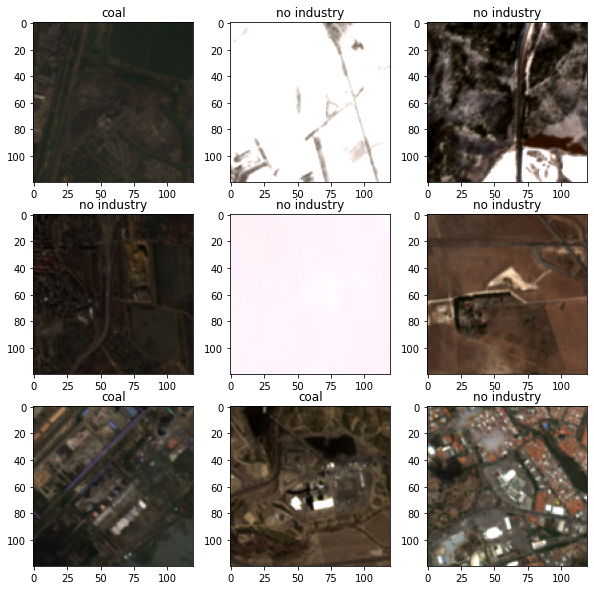

In [77]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    next_element = iterator.get_next()
    im = resize_rescale_augment(next_element[0])
    plt.imshow(np.flip(im[0,:,:,0:3], axis=2))
    plt.title(convert_onehot(next_element))

In [75]:
def convert_onehot(next_element):
    if (next_element[1].numpy() == np.array([0, 0, 1])).all(): return 'no industry'
    elif (next_element[1].numpy() == np.array([0, 1, 0])).all(): return 'steel'
    elif (next_element[1].numpy() == np.array([1, 0, 0])).all(): return 'coal'
    else: return 'not valid'

In [166]:
next_element[1].numpy().all()

False

In [238]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/path/to/file.py")
foo = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = foo
spec.loader.exec_module(foo)

'E:\\Users\\sentinel_industry'

In [239]:
! PATH

PATH=C:\Anaconda3_64\envs\minitf\lib\site-packages\pywin32_system32;C:\Anaconda3_64\envs\minitf;C:\Anaconda3_64\envs\minitf\Library\mingw-w64\bin;C:\Anaconda3_64\envs\minitf\Library\usr\bin;C:\Anaconda3_64\envs\minitf\Library\bin;C:\Anaconda3_64\envs\minitf\Scripts;C:\Anaconda3_64\envs\minitf\bin;C:\Anaconda3_64\condabin;C:\Anaconda3_64;C:\Anaconda3_64\Library\mingw-w64\bin;C:\Anaconda3_64\Library\usr\bin;C:\Anaconda3_64\Library\bin;C:\Anaconda3_64\Scripts;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0;C:\Windows\System32\OpenSSH;C:\Program Files\Docker\Docker\resources\bin;C:\ProgramData\DockerDesktop\version-bin;C:\Program Files\Microsoft VS Code\bin;C:\Users\manpet\AppData\Local\Microsoft\WindowsApps;.;C:\Anaconda3_64\envs\minitf\lib\site-packages\numpy\.libs
